# Exploratory Data Analysis Problem

In case you do not dispose from a local environment please launch this repository from 

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Talan-TechForData/datascience-solutions/HEAD?labpath=problem.ipynb) 
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Talan-TechForData/datascience-solutions/blob/main/1_exploratory_data_analysis/taxinyc_analysis/problem.ipynb)

## Situational description 

Within the folder `1_exploratory_data_analysis/train_analysis/` you will find multiple files containing events from  a time series, this events correspond to messages received from trains 
where each line corresponds to an event registred by the train. 

1. For this case only few codes have been selected.
2. A regular table contains the following structure:

| Date       | Hour    | State | Code                   | Train | CarNumber | Equipement | Pressure |
|------------|----------|-------|------------------------|-------|-----------|------------|----------|
| 2022-11-01 | 23:52:18 | App   | Pressure | TR_105 | C5        | 3D         | 2.94     |

Where corresponds to: 
- `Date`  the date of the event
- `Hour`  the hour of the event
- `State` a binary value determining wether the event has appeared or dissappeared. This means the event has a duration that can be computed 
  between the arrival (App) and its subsequent dissapeareance (Disp)
- `Code`  the code concerned
- `Train` the involved Train
- `CarNumber` the involved wagon
- `Equipement` the impacted equipement within the wagon. (For example a specific door of a wagon)

### Questions to Answer 

Extract information within the files into a `DataFrame` and examine the following questions:

1. How many trains are observed? 
2. Which are the potential wagon names? 
3. What are the name of the different equipements found in the dataset? 
4. Which periods of time are involved within the analysis?
5. Which is the `Code` which is more frequently sent? 
6. How many messages per day can be observed along the whole fleet?
7. Which is the average time between the arrival and the disappearence of an event?
8. What is the average pressure per day along the fleet? (Plot this timeseries)
9. In case you can propose to forecast ahead the pressure what would this be? 
10. Implement this model!

In [1]:
%pip install pandas matplotlib scikit-learn tensorflow


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


1. How many trains are observed? 

In [2]:
import pandas as pd 
from pathlib import Path 

p = Path(".") / "data"
df = pd.concat(
    [pd.read_csv(f, index_col=False) for f in p.glob("file*.csv")],
    ignore_index=True
)
df = df.iloc[:,1:]
len(df.Train.unique())
df

,Date,Hour,State,code,Train,CarNumber,Equipement,Pressure
0,2022-06-01,23:50:58,Disp,Door,82TR_,C4,1G,3.04
1,2022-06-01,23:50:57,App,Door,82TR_,C4,1G,3.04
2,2022-06-01,23:34:12,Disp,Door,78TR_,C4,1D,2.94
3,2022-06-01,23:34:11,App,Door,78TR_,C4,1D,2.94
4,2022-06-01,23:29:48,Disp,Door,96TR_,C2,3D,2.89
...,...,...,...,...,...,...,...,...
311184,2022-04-30,00:00:51,App,Door,95TR_,C1,2G,2.99
311185,2022-04-30,00:00:51,Disp,DoorGeneral,95TR_,T,-,2.99
311186,2022-04-30,00:00:51,Disp,Door,95TR_,C2,3D,2.99
311187,2022-04-30,00:00:51,Disp,Door,95TR_,C5,3D,2.99


2. Which are the potential wagon names? 

In [3]:
df.code.unique()

array(['Door', 'Pressure', 'DoorGeneral', 'SlowDoor'], dtype=object)

3; What are the name of the different equipements found in the dataset? 

In [4]:
df.Equipement.unique()

array(['1G', '1D', '3D', '-', '2G', '3G', '2D'], dtype=object)

4. Which periods of time are involved within the analysis?


In [5]:
pd.to_datetime(df.Date).describe().loc[["min","max"]]

min    2022-01-01 00:00:00
max    2022-06-30 00:00:00
Name: Date, dtype: object

5. Which is the `Code` which is more frequently sent? 

In [6]:
df.code.value_counts(normalize=True).head(1)

code
Door    0.681618
Name: proportion, dtype: float64

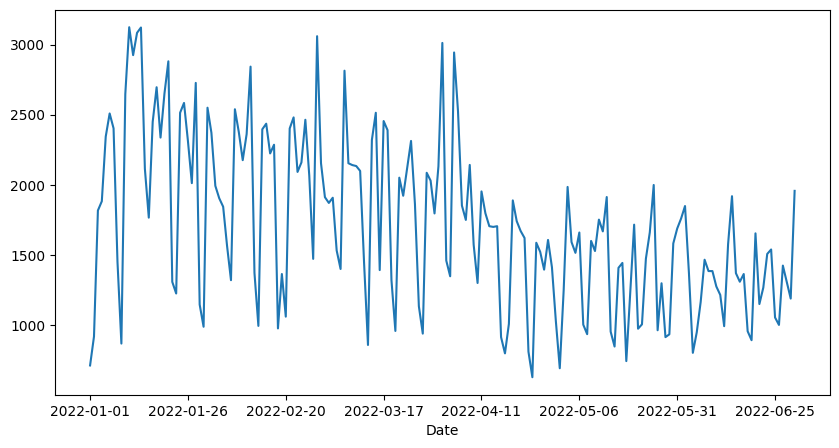

In [7]:
from matplotlib import pyplot as plt 
f, ax = plt.subplots(figsize=(10,5))
ax = df.groupby(["Date"])["code"].count().plot(ax=ax);

7. Which is the average time between the arrival and the disappearence of an event?

In [8]:
app = df[df["State"]=="App"].copy()
app["Hour"] = app["Hour"].astype('timedelta64[s]')
dsp = df[df["State"]=="Disp"].copy()
dsp["Hour"] = dsp["Hour"].astype("timedelta64[s]")

df_delta = pd.merge_asof(
    app.drop(columns="Pressure").sort_values("Hour"),
    dsp.drop(columns="Pressure").sort_values("Hour").assign(time = lambda x: x["Hour"]),
    by=["Date", "Train","CarNumber","Equipement","code"],
    on="Hour",
    direction="forward",
    suffixes=("","_dsp")
)

df_delta["delta"] = df_delta["time"] - df_delta["Hour"]
df_delta["delta"].describe()

count             155541
mean     0 days 00:00:31
std      0 days 00:07:18
min      0 days 00:00:00
25%      0 days 00:00:00
50%      0 days 00:00:01
75%      0 days 00:00:02
max      0 days 11:43:52
Name: delta, dtype: object

8. What is the average pressure per day along the fleet? (Plot this timeseries)


<Axes: xlabel='Date'>

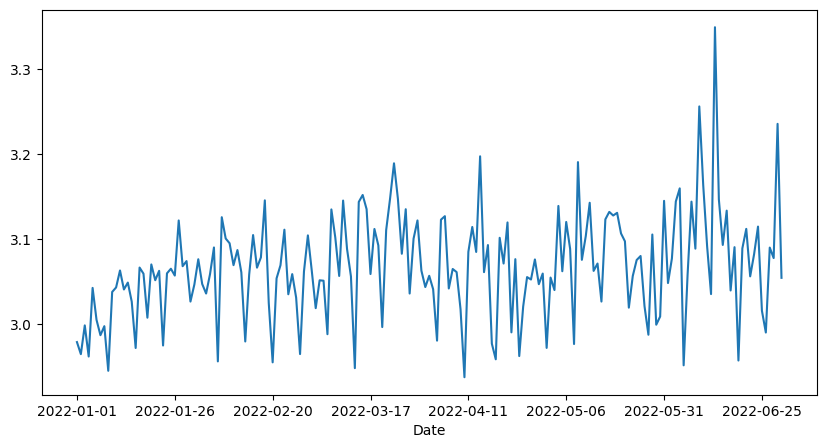

In [9]:
import numpy as np
f, ax = plt.subplots(figsize=(10,5))
df.replace({"-":np.nan}).astype({"Pressure":"float64"}).groupby("Date")["Pressure"].mean().plot(ax=ax)

9. In case you can propose to forecast ahead the pressure what would this be? 

   One of the potential models in this case is ARIMA/SARIMA ou LSTM 

   - ARIMA/SARIMA: Pros (Calibrated), Considers seasonality 

   - LSTM: It does not require calibration parameters
   
10. Implement this model!

In [11]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

# Pre processing
filtered_df = df[df['code'] != 'Pressure']
filtered_df1=filtered_df

#combine the 'Date' and 'Hour' columns onto a single column 'datetime'
filtered_df1['datetime'] = pd.to_datetime(filtered_df['Date'] + ' ' + filtered_df['Hour'])
filtered_df1 = filtered_df1.drop(columns=['Date', 'Hour'])

#convert 'Pressure' to float
filtered_df1['Pressure'] = pd.to_numeric(filtered_df1['Pressure'], errors='coerce')

#Group per day
grouped_by_date = filtered_df1.groupby(filtered_df1['datetime'].dt.date)

#find average pressure per day
average_pressure_per_day = grouped_by_date['Pressure'].mean()
data = average_pressure_per_day.values.reshape(-1, 1)

#normalizing the data using the minmax scaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Split data 
def create_sequences(data, seq_length):
    xs = []  #input sequences
    ys = []  #target values
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10  #number of days used to predict the next day
X, y = create_sequences(data_scaled, seq_length)
X = X.reshape((X.shape[0], X.shape[1], 1))  #reshape X to be 3-dimensional for model input

#define the split point
split_index = int(len(X) * 0.8)

#spliting the data into training and validation sets
X_train, X_val = X[:split_index], X[split_index:]  #training and validation inputs
y_train, y_val = y[:split_index], y[split_index:]  #training and validation targets


model = Sequential([
    #first LSTM layer
    LSTM(50, activation='relu', return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    #dropout layer to prevent overfitting by randomly setting 20% of inputs to zero
    Dropout(0.2),
    #second LSTM layer
    LSTM(50, activation='relu'),
    #another dropout layer to prevent overfitting
    Dropout(0.2),
    #dense layer
    Dense(1)
])

/tmp/ipykernel_3138573/363861007.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df1['datetime'] = pd.to_datetime(filtered_df['Date'] + ' ' + filtered_df['Hour'])
2024-07-02 18:07:00.304918: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/X2028402/.cache/pypoetry/virtualenvs/datasciencesolutions-wKc0EPb8-py3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
#compiling the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

#summary of the model
model.summary()
#training the model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val), verbose=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.1054 - val_loss: 0.1432
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0815 - val_loss: 0.1084
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0518 - val_loss: 0.0699
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0231 - val_loss: 0.0417
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0163 - val_loss: 0.0414
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0236 - val_loss: 0.0403
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0176 - val_loss: 0.0453
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0177 - val_loss: 0.0472
Epoch 9/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0163 - val_loss: 0.0456
Epoch 10/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0177 - val_loss: 0.0431
Epoch 11/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0166 - val_loss: 0.0418
Epoch 12/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0177 - val_lo

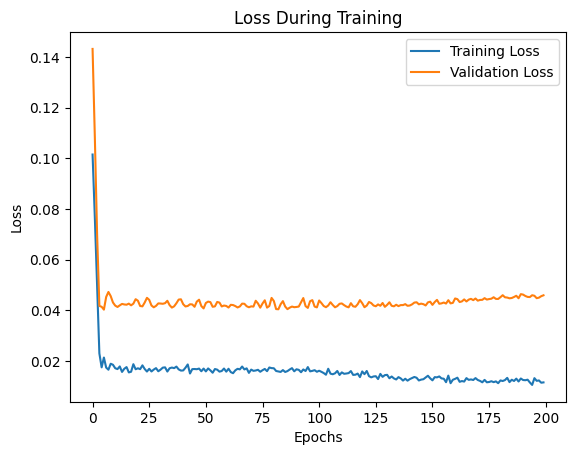

In [13]:
#plot the training loss
plt.plot(history.history['loss'], label='Training Loss')
#plot the validation loss
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


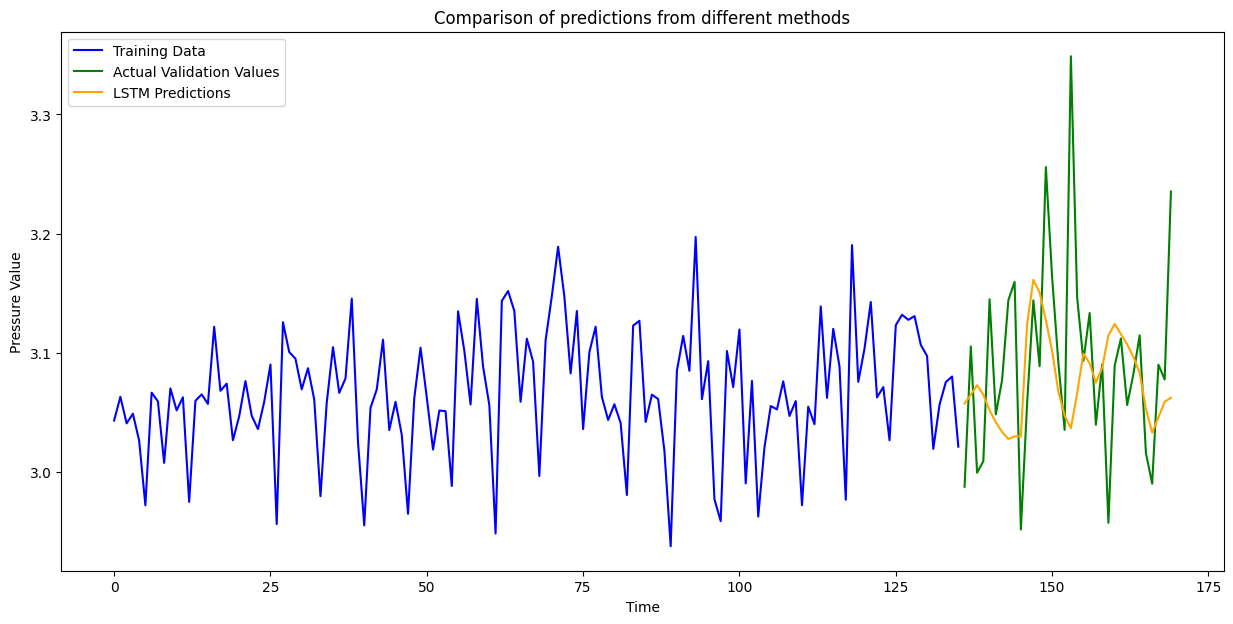

In [16]:
predicted_val = model.predict(X_val)
#transform back to the original scale
predicted_val = scaler.inverse_transform(predicted_val)

#indices for training and validation data
train_indices = range(len(y_train))
val_indices = range(len(y_train), len(y_train) + len(y_val))

#plotting the predictions of all the models
plt.figure(figsize=(15, 7))
plt.plot(train_indices, scaler.inverse_transform(y_train.reshape(-1, 1)), label='Training Data', color='blue')
plt.plot(val_indices, scaler.inverse_transform(y_val.reshape(-1, 1)), label='Actual Validation Values', color='green')

plt.plot(val_indices, predicted_val, label='LSTM Predictions', color='orange')

plt.title('Comparison of predictions from different methods')
plt.xlabel('Time')
plt.ylabel('Pressure Value')
plt.legend()
plt.show()

# Fin